### APRENDIZAJE PROFUNDO PARA PROCESAMIENTO DE INFORMACIÓN BIOMÉTRICA

# PRÁCTICA 1
### GRUPO 
* Hajar Boulehdid
* Sofía Santos Schmick
* Andrés Teruel Fernández

---


In [1]:
import os
import numpy as np

# Remove most annoying tensorflow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from pathlib import Path
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_val_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from andres_face_recognition_main import *

---

## DEFINICIÓN DE RUTAS Y CARGA DE LOS DATOS.

In [2]:
# Paths and parameters:
data_dir = os.path.join('..', 'data')

images_dir = os.path.join(data_dir, 'imagenes')

bbdd_10_ppl_dir = os.path.join(data_dir, 'bbdd_10_personas')
embeddings_10_ppl_dataset_path = os.path.join(data_dir, '\.pkl')

imgs_dataset_dir = os.path.join(data_dir,'DiveFace4K_120', '4K_120')
embeddings_dataset_path = os.path.join(data_dir,'embeddings_dataset.pkl')

In [3]:
if os.path.isfile(embeddings_10_ppl_dataset_path):
    print("Embeddings dataset already exists. Loading...")

else:
    print("Embeddings dataset does not exists. Creating it...")
    embeddings_10_ppl_dataset = create_embeddings_10_ppl_dataset(bbdd_10_ppl_dir, embeddings_10_ppl_dataset_path)
    
    
# Load pickle object
with open(embeddings_10_ppl_dataset_path, "rb") as file:
    embeddings_10_ppl_dataset = pickle.load(file)

print("Embeddings dataset loaded.")

Embeddings dataset already exists. Loading...
Embeddings dataset loaded.


In [4]:
if os.path.isfile(embeddings_dataset_path):
    print("Embeddings dataset already exists. Loading...")
    
else:
    print("Embeddings dataset does not exists. Creating and loading the dataset...")
    create_1000embeddings_dataset(imgs_dataset_dir, embeddings_dataset_path)
        
        
# Load pickle object
with open(embeddings_dataset_path, "rb") as file:
    embeddings_dict = pickle.load(file)
    
print("Embeddings dataset loaded.")

Embeddings dataset already exists. Loading...
Embeddings dataset loaded.


---

## TAREA 1.0:

 - Revisa y entiende el código
 - Compara con la imagen 2 o 3 con las anterires.

In [5]:
""""Comparamos si son la misma persona a través de una simple.Detectamos las caras de las imagenes. Imagen0 y Imagen1"""
images = [os.path.join(images_dir, f"{i}.jpg") for i in range(4)]

for i in range(len(images)):
    for j in range(i + 1, len(images)):
        image1 = images[i]
        image2 = images[j]
        
        print(f"Image {i} vs image {j}: ", end='')
        compare_images(image1, image2)

Image 0 vs image 1: Las imágenes pertenecen a la misma persona con similitud 0.61
Image 0 vs image 2: Las imágenes pertenecen a diferentes personas con similitud 0.33
Image 0 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.36
Image 1 vs image 2: Las imágenes pertenecen a diferentes personas con similitud 0.38
Image 1 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.24
Image 2 vs image 3: Las imágenes pertenecen a diferentes personas con similitud 0.21


---

## TAREA 1.1: 

 - Generate a small database with a minimum of 3 images per person and 10 persons.
 - Develop a script to calculate the FAR and FRR curves.   

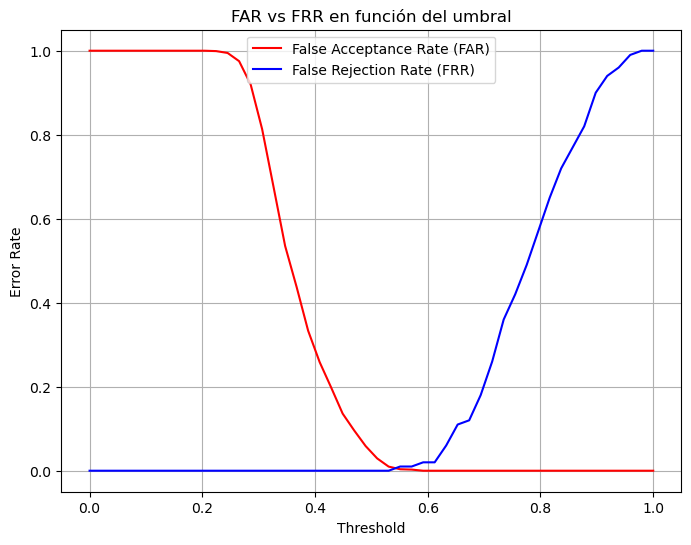

In [6]:
# Generar FAR, FRR y el gráfico
fars, frrs = calculate_far_frr_plot(embeddings_10_ppl_dataset)

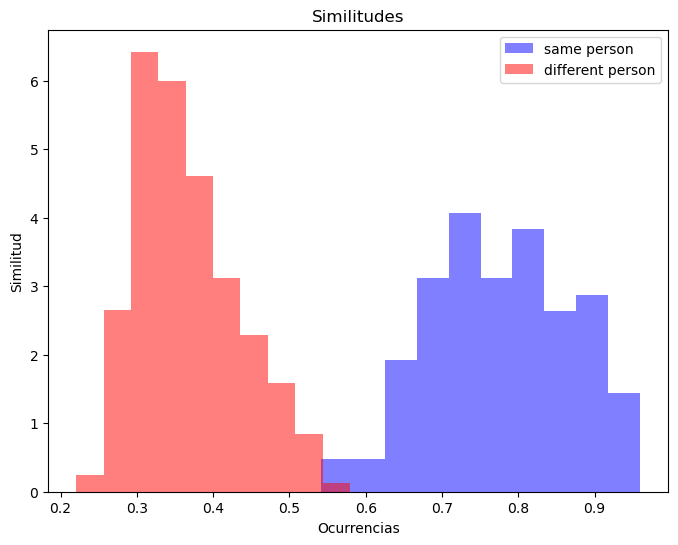

In [7]:
same_person, different_person = calcular_histograma(embeddings_10_ppl_dataset)

---

## TAREA 1.2:

 - Read the DiveFace database and obtain the embeddings of 50 face images (1 image per subject) from the 6 demographic groups (50*6=300 embeddings in total).
 - DiveFace contains face images from 3 demographic groups (3 ethnicity and 2 gender)

In [15]:
# Llamar a la función para crear la base de datos de embeddings
embeddings_db_demographic = create_embeddings_subset(embeddings_dict, 200)

# Verificar la cantidad de embeddings por grupo
for group_name, embeddings in embeddings_db_demographic.items():
    print(f"{group_name}: {len(embeddings)} embeddings")

MN4K_120: 200 embeddings
HN4K_120: 200 embeddings
MB4K_120: 200 embeddings
HB4K_120: 200 embeddings
HA4K_120: 200 embeddings
MA4K_120: 200 embeddings


---

## TAREA 1.3:

 - Using t-SNE, represent the embeddings and its demographic group. Can you differentiate the different demographic groups?
 

Shape de embeddings_matrix: (1200, 2048)
Shape de embeddings_matrix antes de t-SNE: (1200, 2048)


/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


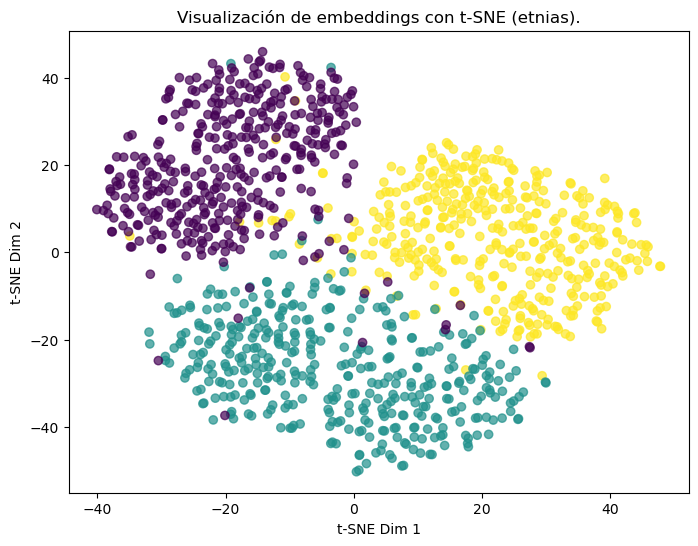

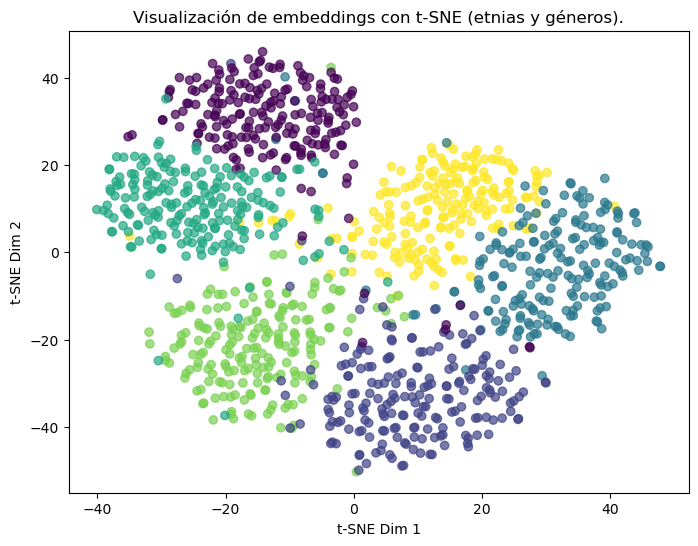

In [28]:
# Aplicar t-SNE a los embeddings
apply_tsne(embeddings_db_demographic)

---

## TAREA 1.4:
 * Using the ResNet-50 embedding (freeze the model), train your own attribute classifiers (ethnicity and gender). 
 *  Recommendation: use a simple dense layer with a softmax output. Divide DiveFace into train and test.

TODO: revisar la presentación porque ponía alguna cosa sobre este apartado

In [10]:
X_train, X_test, y_ethnicity_train, y_ethnicity_test, y_gender_train, y_gender_test = preprocess_embeddings_for_trainning(embeddings_db_demographic)

In [15]:
# embeddings_db_demographic[embeddings_db_demographic.keys[0]]
embeddings_db_demographic.keys()

dict_keys(['HN4K_120', 'HB4K_120', 'MN4K_120', 'HA4K_120', 'MA4K_120', 'MB4K_120'])

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np


# ResNet-50 model is already loaded
base_model = model

# Freeze the model
base_model.trainable = False  # Ensures ResNet-50 layers are not updated

# Select the last convolutional layer for feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert features to a fixed-length vector

ethnicity_output = Dense(3, activation='softmax', name='ethnicity')(x)  # Example: 3 classes
gender_output = Dense(2, activation='softmax', name='gender')(x)  # Example: 2 classes (Male, Female)

# Define the new model
model = Model(inputs=base_model.input, outputs=[ethnicity_output, gender_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'ethnicity': 'categorical_crossentropy', 'gender': 'categorical_crossentropy'},
              metrics={'ethnicity': 'accuracy', 'gender': 'accuracy'})

NameError: name 'GlobalAveragePooling2D' is not defined

In [ ]:


# Load the pretrained ResNet-50 model
model_file = 'resnet50.h5'
base_model = tf.keras.models.load_model(model_file)

# Freeze the model
base_model.trainable = False  # Ensures ResNet-50 layers are not updated

# Select the last convolutional layer for feature extraction
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Convert features to a fixed-length vector

# Attribute classifier (Ethnicity & Gender)
ethnicity_output = Dense(3, activation='softmax', name='ethnicity')(x)  # Example: 3 classes
gender_output = Dense(2, activation='softmax', name='gender')(x)  # Example: 2 classes (Male, Female)

# Define the new model
model = Model(inputs=base_model.input, outputs=[ethnicity_output, gender_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'ethnicity': 'categorical_crossentropy', 'gender': 'categorical_crossentropy'},
              metrics={'ethnicity': 'accuracy', 'gender': 'accuracy'})

# Train the model
model.fit(X_train, {'ethnicity': y_ethnicity_train, 'gender': y_gender_train},
          validation_data=(X_test, {'ethnicity': y_ethnicity_test, 'gender': y_gender_test}),
          epochs=10, batch_size=32)


In [ ]:
X = all_embeddings

# Convertir etiquetas a números
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)  # Convierte categorías en enteros

# Convertir a One-Hot Encoding
y = to_categorical(y, num_classes=6)  # Si hay 6 clases

print("X shape:", X.shape)
print("y shape:", y.shape)

In [ ]:

for layer in feature_extractor.layers:
    layer.trainable = False  # Congelar capas


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

num_classes = y.shape[1]  # Asegura que coincida con las categorías

classifier = Sequential([
    Input(shape=(X.shape[1],)),  # Tamaño de los embeddings
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')  # Clasificación multiclase
])

classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

classifier.summary()
classifier.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))
loss, accuracy = classifier.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')


In [ ]:
input_size = 2048

def baseline_model():
    model = Sequential()
    model.add(Dense(60, input_dim=2048, activation='relu'))
    model.add(Dense(6, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Compile model
X = np.array(X).astype(float)
y = np.asarray(y)
y = np_utils.to_categorical(y)
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))